# Importação de Bibliotecas

In [105]:
import pandas as pd
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN,AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA, TruncatedSVD
from kneed import KneeLocator
from collections import Counter
import math
from copy import deepcopy
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings("ignore")

# Utils

In [106]:
def replace_nan_with_row_median(matrix):
    row_medians = np.nanmedian(matrix, axis=1)
    inds = np.where(np.isnan(matrix))
    matrix[inds] = np.take(row_medians, inds[0])
    return matrix

def normalize_data(matrix):
    row_means = np.mean(matrix, axis=1, keepdims=True)
    row_stds = np.std(matrix, axis=1, keepdims=True)
    row_stds[row_stds == 0] = 1
    normalized_matrix = (matrix - row_means) / row_stds
    
    return normalized_matrix

def calculate_distance_matrix(matrix, metric='euclidean'):
    dist_matrix = pdist(matrix, metric=metric)
    dist_matrix_square = squareform(dist_matrix)
    
    return dist_matrix_square

def calculate_wcss(data):
    inertia = []
    for n in range(2, 51):
        kmeans = KMeans(n_clusters=n, random_state=42)
        kmeans.fit(X=data)
        inertia.append(kmeans.inertia_)

    return inertia


def calculate_knee_point(distances):
    distances = np.sort(distances)
      
    n_points = len(distances)
    all_coords = np.vstack((range(n_points), distances)).T
    
    first_point = all_coords[0]
    last_point = all_coords[-1]
    line_vec = last_point - first_point
    
    line_vec_norm = line_vec / np.linalg.norm(line_vec)
    vec_from_first = all_coords - first_point
    
    scalar_product = np.sum(vec_from_first * np.matlib.repmat(line_vec_norm, n_points, 1), axis=1)
    vec_from_first_parallel = np.outer(scalar_product, line_vec_norm)
    vec_to_line = vec_from_first - vec_from_first_parallel
    
    dist_to_line = np.sum(vec_to_line ** 2, axis=1)
    
    index_of_best_point = np.argmax(dist_to_line)
    
    return index_of_best_point

def cluster_visualization(data: pd.DataFrame, labels, title, genre_key='genres'):
    
    generos_unicos = set()
    for generos in data[genre_key].unique():
        for genero in generos.split('|'):
            generos_unicos.add(genero)

    cluster_genero_predominante = {}

    for cluster in sorted(data[labels].unique()):
        cluster_df = data[data[labels] == cluster]
        genero_counts = {genero: 0 for genero in generos_unicos}

        for generos in cluster_df[genre_key].dropna():
            for genero in generos.split('|'):
                if genero in genero_counts:
                    genero_counts[genero] += 1

        total_filmes_no_cluster = len(cluster_df)

        if genero_counts:
            genero_predominante = max(genero_counts, key=genero_counts.get)
            porcentagem = (genero_counts[genero_predominante] / total_filmes_no_cluster) * 100
        else:
            genero_predominante = None
            porcentagem = 0

        cluster_genero_predominante[cluster] = (genero_predominante, porcentagem)

    all_clusters = set(range(data[labels].max() + 1))
    present_clusters = set(cluster_genero_predominante.keys())
    missing_clusters = all_clusters - present_clusters

    for cluster in missing_clusters:
        cluster_genero_predominante[cluster] = (None, 0)

    results_df = pd.DataFrame(cluster_genero_predominante, index=['Genre', 'Percentage']).T
    results_df = results_df.reset_index().rename(columns={'index': 'Cluster'}).sort_values(by='Cluster')

    plt.figure(figsize=(10, 6))
    bars = plt.bar(results_df['Cluster'], results_df['Percentage'], color='skyblue')
    plt.xlabel('Cluster')
    plt.ylabel('Percentage of Predominant Genre')
    plt.title(title)

    for bar, genre in zip(bars, results_df['Genre']):
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, genre if genre else 'None', ha='center', va='bottom')

    plt.show()

# Carregamento dos dados

In [107]:
ratings = pd.read_csv(rf'ratings.dat', sep='::', header=None, engine='python', encoding= "utf-8", names=['user_id', 'movie_id', 'rating', 'timestamp'])
movies = pd.read_csv(rf'movies.dat', sep='::', header=None, engine='python', encoding= "utf-8", names=['movie_id', 'title', 'genres'], encoding_errors='ignore')

display(ratings.info())
display(movies.info())
display(ratings.head())
display(movies.head())
num_movies = movies['movie_id'].nunique()
print(F'numero de filmes unicos: {num_movies}')
num_users = ratings['user_id'].nunique()
print(F'numero de usuarios unicos: {num_users}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1000209 non-null  int64
 1   movie_id   1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


None

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


numero de filmes unicos: 3883
numero de usuarios unicos: 6040


# Visualização de Dados

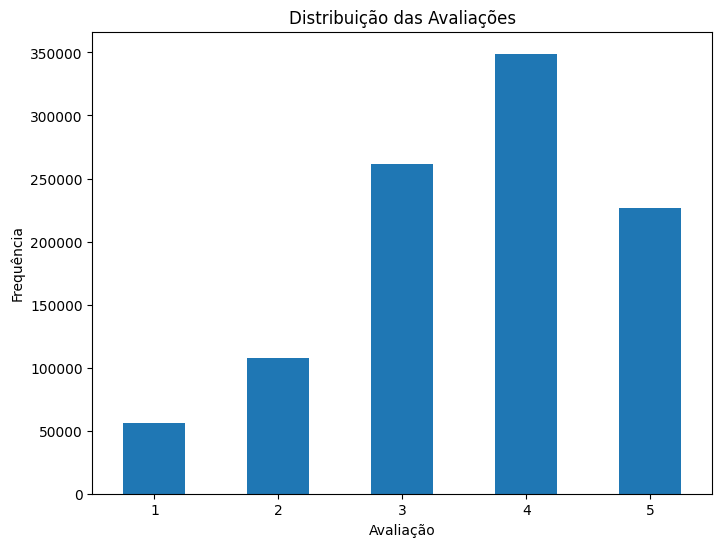

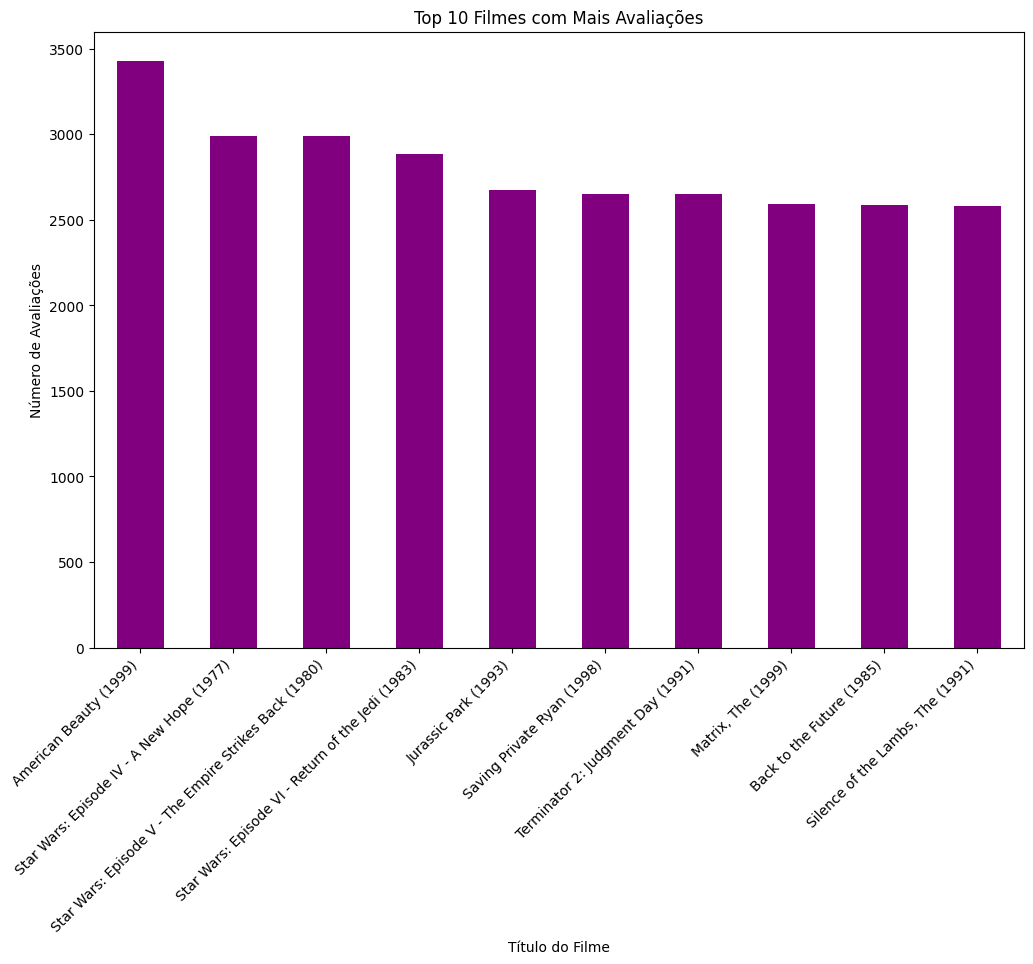

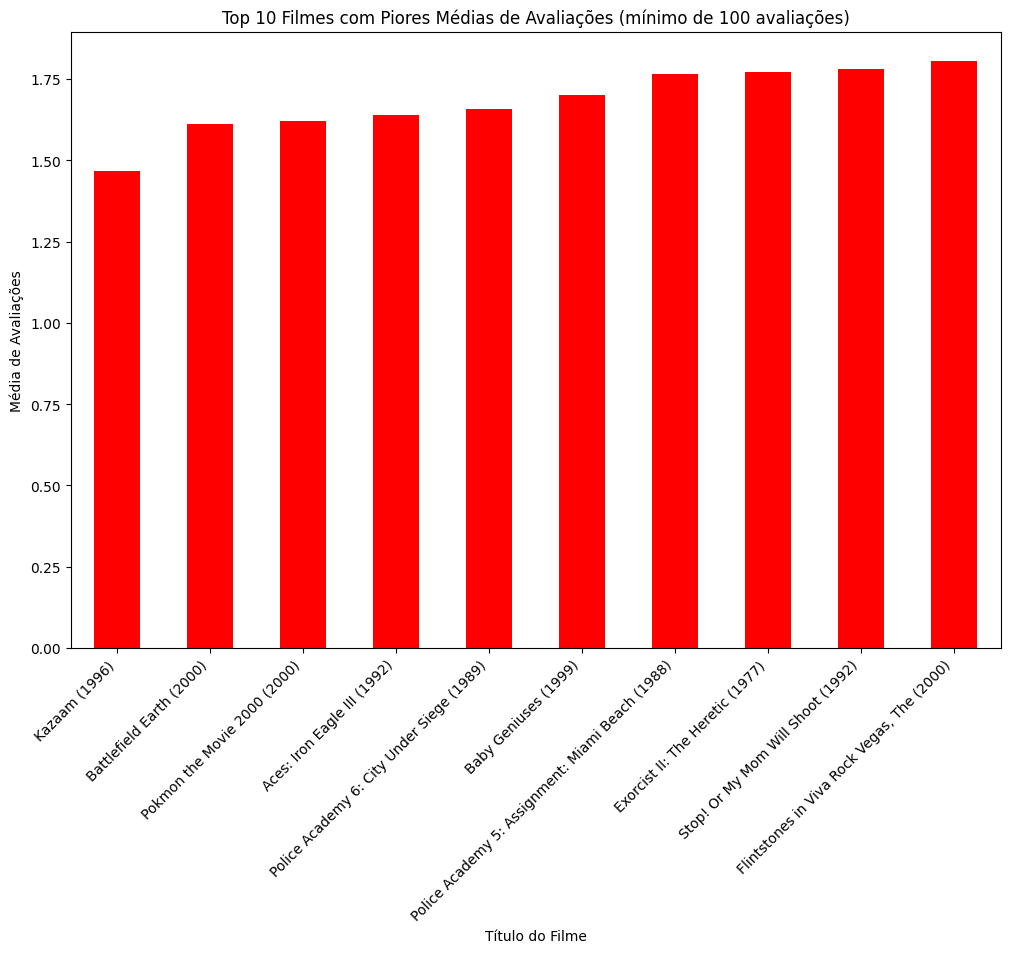

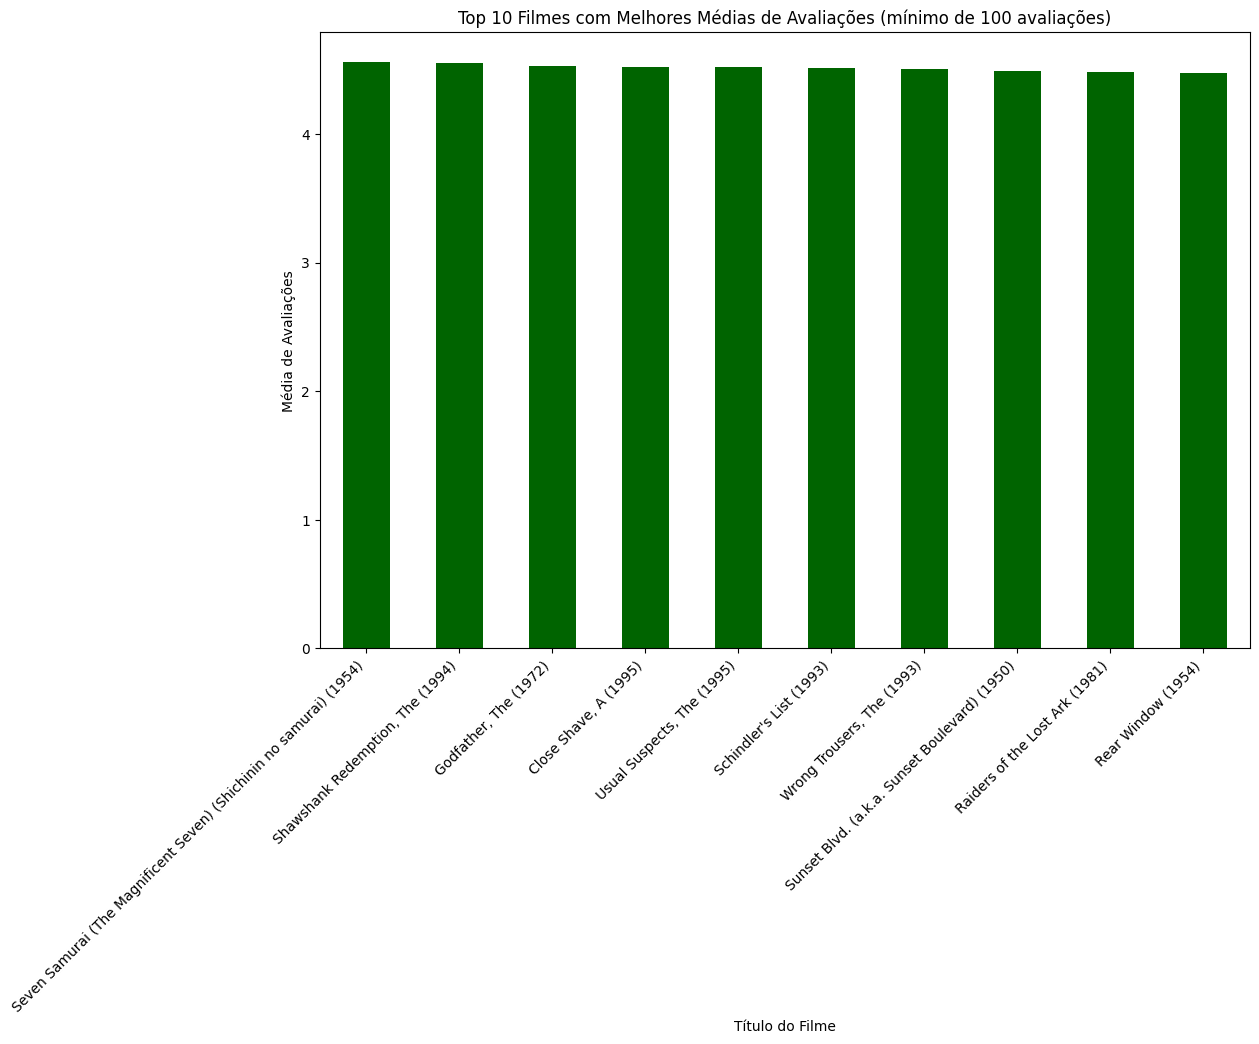

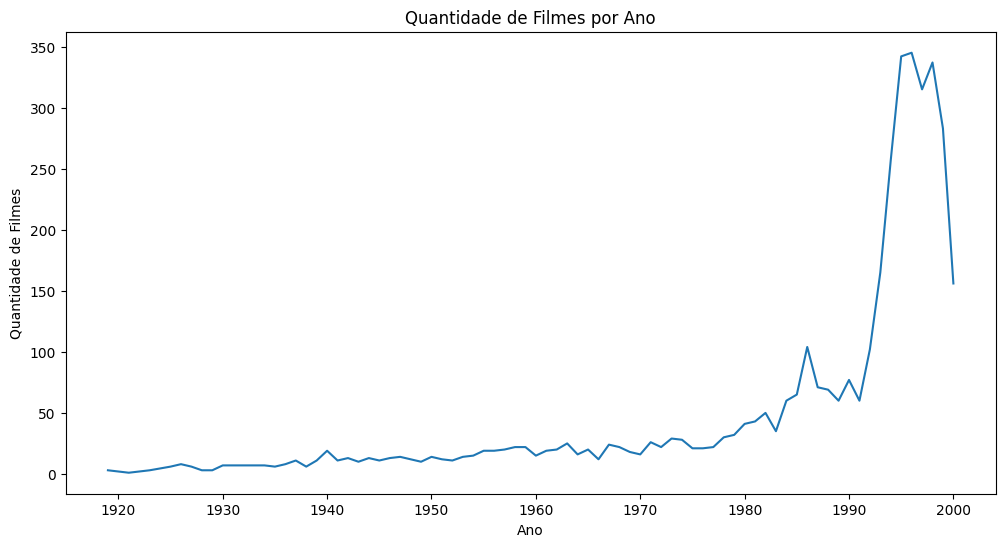

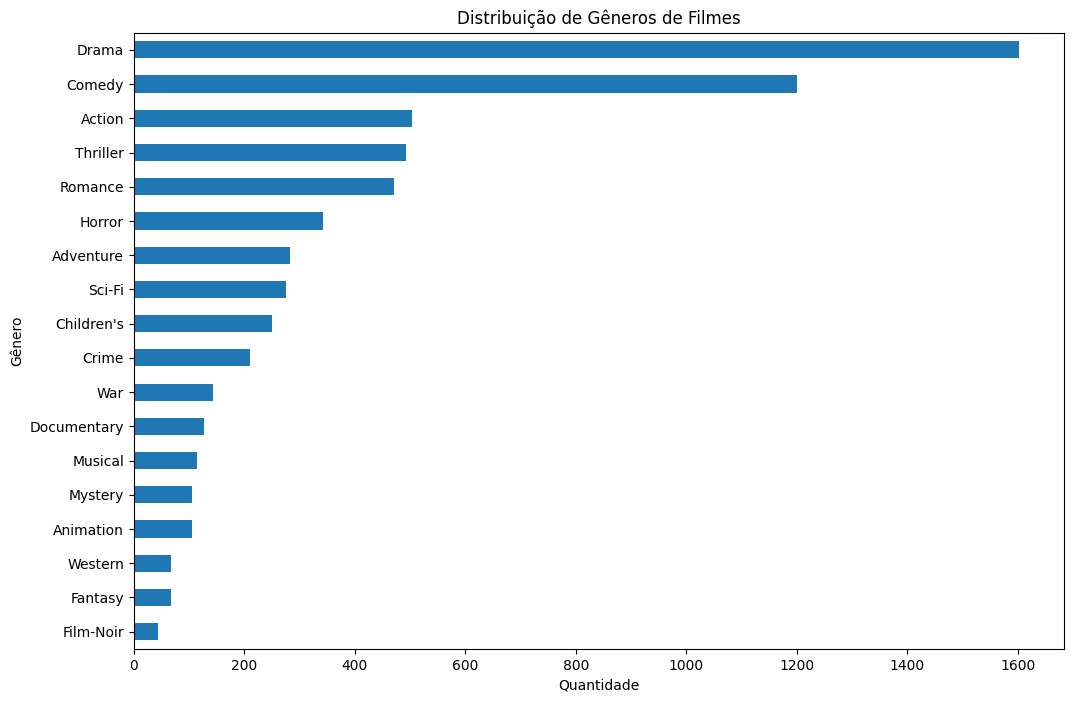

In [108]:
plt.figure(figsize=(8, 6))
ratings['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribuição das Avaliações')
plt.xlabel('Avaliação')
plt.ylabel('Frequência')
plt.xticks(rotation=0)
plt.show()

movie_rating_counts = ratings['movie_id'].value_counts().head(10)

top_rated_movies = movies.set_index('movie_id').loc[movie_rating_counts.index, 'title']

plt.figure(figsize=(12, 8))
movie_rating_counts.plot(kind='bar', color='purple')
plt.title('Top 10 Filmes com Mais Avaliações')
plt.xlabel('Título do Filme')
plt.ylabel('Número de Avaliações')
plt.xticks(ticks=range(10), labels=top_rated_movies, rotation=45, ha='right')
plt.show()

movie_avg_ratings = ratings.groupby('movie_id').agg({'rating': ['mean', 'count']})
movie_avg_ratings.columns = ['AverageRating', 'Count']
top_average_rated_movies = movie_avg_ratings[movie_avg_ratings['Count'] >= 100].sort_values(by='AverageRating', ascending=False).head(10)

top_avg_rated_movie_titles = movies.set_index('movie_id').loc[top_average_rated_movies.index, 'title']

worst_average_rated_movies = movie_avg_ratings[movie_avg_ratings['Count'] >= 100].sort_values(by='AverageRating', ascending=True).head(10)

worst_avg_rated_movie_titles = movies.set_index('movie_id').loc[worst_average_rated_movies.index, 'title']

plt.figure(figsize=(12, 8))
worst_average_rated_movies['AverageRating'].plot(kind='bar', color='red')
plt.title('Top 10 Filmes com Piores Médias de Avaliações (mínimo de 100 avaliações)')
plt.xlabel('Título do Filme')
plt.ylabel('Média de Avaliações')
plt.xticks(ticks=range(10), labels=worst_avg_rated_movie_titles, rotation=45, ha='right')
plt.show()


plt.figure(figsize=(12, 8))
top_average_rated_movies['AverageRating'].plot(kind='bar', color='darkgreen')
plt.title('Top 10 Filmes com Melhores Médias de Avaliações (mínimo de 100 avaliações)')
plt.xlabel('Título do Filme')
plt.ylabel('Média de Avaliações')
plt.xticks(ticks=range(10), labels=top_avg_rated_movie_titles, rotation=45, ha='right')
plt.show()

movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')
movies['year'] = pd.to_numeric(movies['year'], errors='coerce')

plt.figure(figsize=(12, 6))
movies['year'].value_counts().sort_index().plot(kind='line')
plt.title('Quantidade de Filmes por Ano')
plt.xlabel('Ano')
plt.ylabel('Quantidade de Filmes')
plt.show()

genre_counts = Counter(genre for genres in movies['genres'] for genre in genres.split('|'))

plt.figure(figsize=(12, 8))
pd.Series(genre_counts).sort_values().plot(kind='barh')
plt.title('Distribuição de Gêneros de Filmes')
plt.xlabel('Quantidade')
plt.ylabel('Gênero')
plt.show()

# Preprocessamento de dados

## Verificação e Remoção de Valores Duplicados

In [109]:
ratings_before = len(ratings)
ratings.drop_duplicates(inplace=True)
ratings_after = len(ratings)

movies_before = len(movies)
movies.drop_duplicates(subset='movie_id', keep='first', inplace=True)
movies_after = len(movies)

print(f'Duplicatas removidas de ratings: {ratings_before - ratings_after}')
print(f'Duplicatas removidas de movies: {movies_before - movies_after}')

Duplicatas removidas de ratings: 0
Duplicatas removidas de movies: 0


## Tratamento de Dados Faltantes

In [110]:
print(f'Valores faltantes em ratings: \n{ratings.isnull().sum()}')
print(f'Valores faltantes em movies: \n{movies.isnull().sum()}')

Valores faltantes em ratings: 
user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64
Valores faltantes em movies: 
movie_id    0
title       0
genres      0
year        0
dtype: int64


## Remoção de Outliers
Será considerado um outlier qualquer usuário que tenha uma mediana de avaliações maior que 4.5 ou menor que 1.5, uma vez que esses usuários podem ter avaliado os filmes com algum viés externo

In [111]:
user_median_ratings = ratings.groupby('user_id')['rating'].median()
users_outliers = user_median_ratings[(user_median_ratings >= 4.7) | (user_median_ratings <= 2)].index
ratings_filtered = deepcopy(ratings[~ratings['user_id'].isin(users_outliers)])

## Matriz de Avaliações 

In [112]:
movies_in_ratings = deepcopy(movies[movies['movie_id'].isin(ratings_filtered['movie_id'])])

movies_in_ratings['movie_id_true'] = range(1, len(movies_in_ratings) + 1)

ratings_filtered = ratings_filtered.merge(movies_in_ratings[['movie_id', 'movie_id_true']], on='movie_id', how='left')

ratings_matrix = ratings_filtered.pivot_table(index='movie_id_true', columns='user_id', values='rating')

ratings_matrix_np = ratings_matrix.to_numpy()

print(f'ratings_matrix: {ratings_matrix_np}')

ratings_matrix: [[ 5. nan nan ... nan nan  3.]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [113]:
ratings_matrix_np_filled_median = replace_nan_with_row_median(ratings_matrix_np)
print(f'ratings_matrix com NaNs substituídos pela mediana: {ratings_matrix_np_filled_median}')

ratings_matrix com NaNs substituídos pela mediana: [[5. 4. 4. ... 4. 4. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 ...
 [4. 4. 4. ... 4. 4. 4.]
 [4. 4. 4. ... 4. 4. 4.]
 [4. 4. 4. ... 4. 4. 4.]]


## Normalização dos Dados

In [114]:
ratings_matrix_np_normalized = normalize_data(ratings_matrix_np_filled_median)
print(f'ratings_matrix normalizada: {ratings_matrix_np_normalized}')

ratings_matrix normalizada: [[ 1.88193903 -0.0890155  -0.0890155  ... -0.0890155  -0.0890155
  -2.05997003]
 [-0.06895413 -0.06895413 -0.06895413 ... -0.06895413 -0.06895413
  -0.06895413]
 [-0.00777664 -0.00777664 -0.00777664 ... -0.00777664 -0.00777664
  -0.00777664]
 ...
 [ 0.0289739   0.0289739   0.0289739  ...  0.0289739   0.0289739
   0.0289739 ]
 [ 0.0103111   0.0103111   0.0103111  ...  0.0103111   0.0103111
   0.0103111 ]
 [ 0.0597302   0.0597302   0.0597302  ...  0.0597302   0.0597302
   0.0597302 ]]


# Cálculo da Matriz de Distância

In [115]:
dist_matrix_square = calculate_distance_matrix(ratings_matrix_np_normalized)
print(f'Matriz de distâncias: {dist_matrix_square}')

Matriz de distâncias: [[  0.         100.53010928 102.50414353 ... 103.92093657 103.89700062
  103.20681601]
 [100.53010928   0.         102.95418794 ... 104.74084459 104.86259352
  103.55538969]
 [102.50414353 102.95418794   0.         ... 103.10475126 103.51684232
  103.52039594]
 ...
 [103.92093657 104.74084459 103.10475126 ...   0.         103.59061947
  100.92610196]
 [103.89700062 104.86259352 103.51684232 ... 103.59061947   0.
   98.17810162]
 [103.20681601 103.55538969 103.52039594 ... 100.92610196  98.17810162
    0.        ]]


# Aplicação dos Algoritmos de Clusterização

## K-means Clustering
Esta célula do notebook Python realiza a análise de clustering utilizando o algoritmo K-means. O processo é dividido em várias etapas:

1. **Cálculo da Inércia (WCSS)**: A função `calculate_wcss` calcula a soma dos quadrados das distâncias dentro do cluster (WCSS - Within-Cluster Sum of Square) para diferentes números de clusters (de 2 a 20). A inércia é uma medida da coesão interna dos clusters.

2. **Determinação do Número Ótimo de Clusters**: A função `KneeLocator` utiliza o método do cotovelo para determinar o número ótimo de clusters. Este método calcula a distância de cada ponto (representando o WCSS para um determinado número de clusters) até a linha formada pelos pontos extremos (número mínimo e máximo de clusters).

3. **Visualização do Método do Cotovelo**: Utiliza a biblioteca `matplotlib` para plotar o gráfico do método do cotovelo, mostrando como a inércia varia com o número de clusters. Este gráfico ajuda a visualizar o ponto onde o aumento no número de clusters deixa de resultar em melhorias significativas na inércia, indicando o número ótimo de clusters.

4. **Aplicação do K-means com o Número Ótimo de Clusters**: Finalmente, o algoritmo K-means é aplicado usando o número ótimo de clusters determinado anteriormente. O resultado é um modelo capaz de agrupar os dados de entrada em clusters significativos.

Este processo é uma parte fundamental da análise de cluster, permitindo identificar agrupamentos naturais dentro dos dados sem a necessidade de etiquetas pré-definidas.

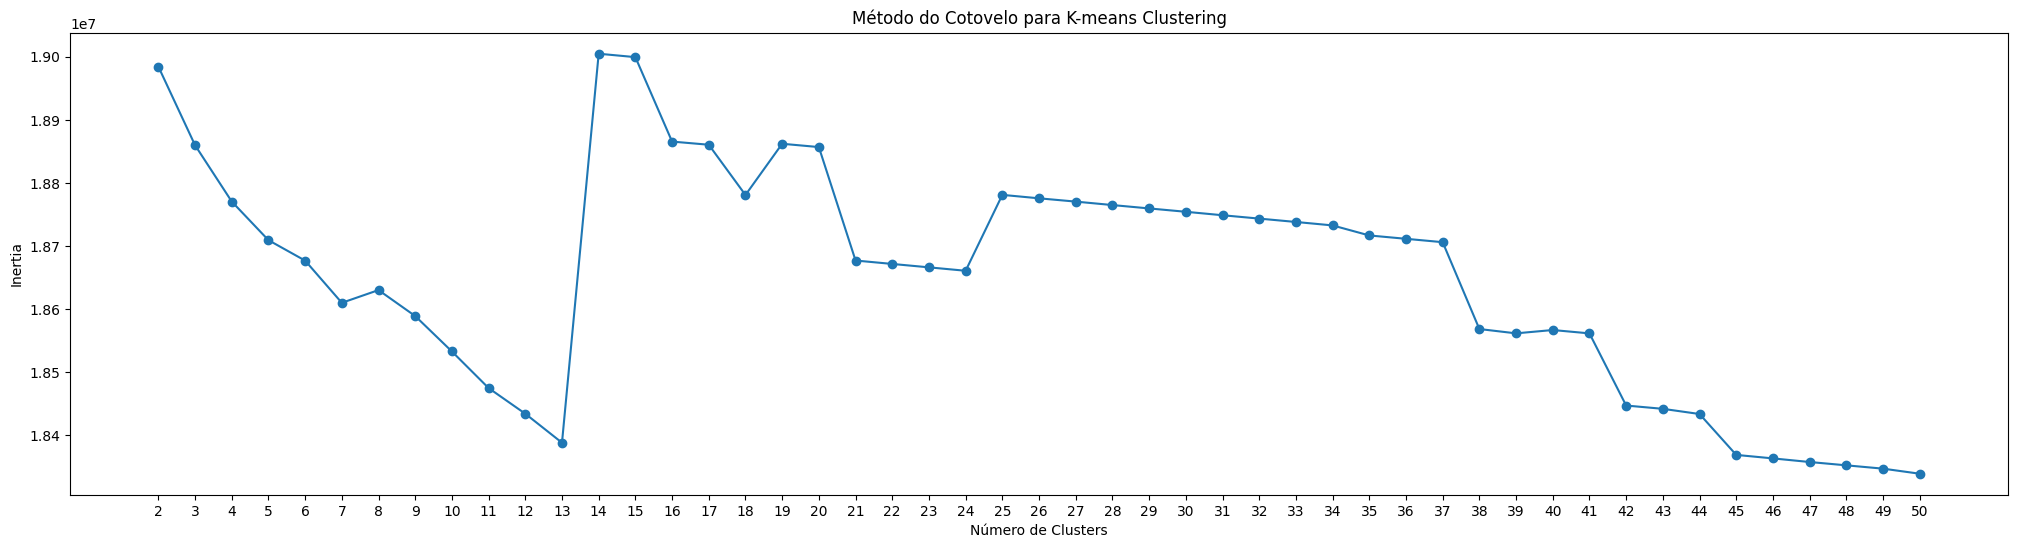

Número ótimo de clusters (KneeLocator): 7


In [116]:
inertia = calculate_wcss(ratings_matrix_np_normalized)
plt.figure(figsize=(25, 6))
plt.plot(range(2, 51), inertia, marker='o')
plt.title('Método do Cotovelo para K-means Clustering')
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.xticks(range(2, 51))
plt.show()

kl = KneeLocator(range(2, 51), inertia, curve="convex", direction="decreasing")
print(f'Número ótimo de clusters (KneeLocator): {kl.elbow}')

In [138]:
kmeans = KMeans(n_clusters=kl.elbow, random_state=42)
kmeans_clusters = kmeans.fit_predict(ratings_matrix_np_normalized)
print("Vizualização dos clusters formados pelo Kmeans:\n", pd.Series(kmeans_clusters).value_counts())

Vizualização dos clusters formados pelo Kmeans:
 4    1184
1     840
2     606
3     461
6     320
0     165
5     115
Name: count, dtype: int64


## DBSCAN
Agora, vamos usar o algoritmo DBSCAN, que é baseado em densidade e pode capturar clusters de formas variadas.

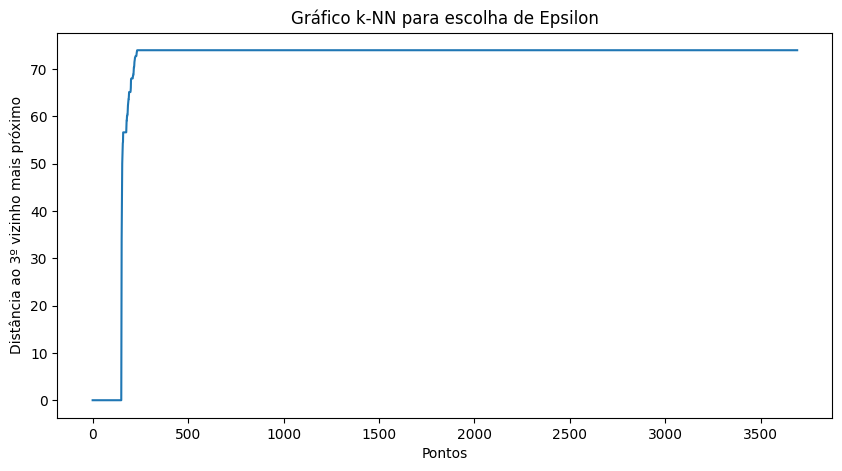

O valor sugerido para Epsilon é: 73.95268757794453


In [118]:
k = 4
neighbors = NearestNeighbors(n_neighbors=k)  
neighbors_fit = neighbors.fit(ratings_matrix_np_normalized)
distances, indices = neighbors_fit.kneighbors(ratings_matrix_np_normalized)
k_distances = distances[:, k-1]
epsilon = calculate_knee_point(k_distances)

sorted_distances = np.sort(distances[:, k-1], axis=0)  
plt.figure(figsize=(10, 5))
plt.plot(sorted_distances)
plt.title("Gráfico k-NN para escolha de Epsilon")
plt.xlabel("Pontos")
plt.ylabel("Distância ao 3º vizinho mais próximo")
plt.show()

print(f"O valor sugerido para Epsilon é: {k_distances[epsilon]}")


In [119]:
dbscan = DBSCAN(eps=k_distances[epsilon], min_samples=k)
dbscan_clusters = dbscan.fit_predict(ratings_matrix_np_normalized)
print("Visualização da formação de clusters:\n", pd.Series(dbscan_clusters).value_counts())

Visualização da formação de clusters:
  0    3673
-1      18
Name: count, dtype: int64


## Clustering Hierárquico

In [120]:
agg_clustering = AgglomerativeClustering(n_clusters=kl.elbow, linkage='complete')
agg_clusters = agg_clustering.fit_predict(dist_matrix_square)
print("Visualização da formação de clusters:\n", pd.Series(agg_clusters).value_counts())

Visualização da formação de clusters:
 0    2728
2     749
3     146
1      41
5      15
4       8
6       4
Name: count, dtype: int64


## Visualizações das Formações de Clusters

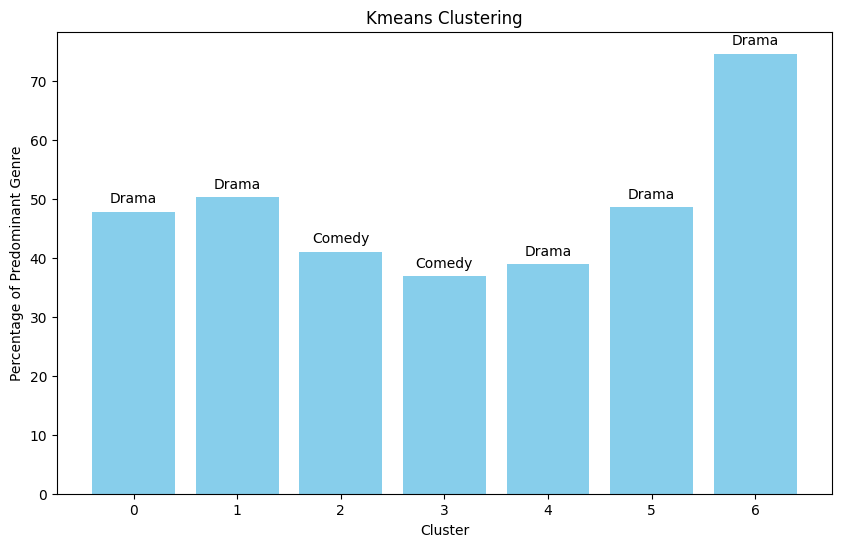

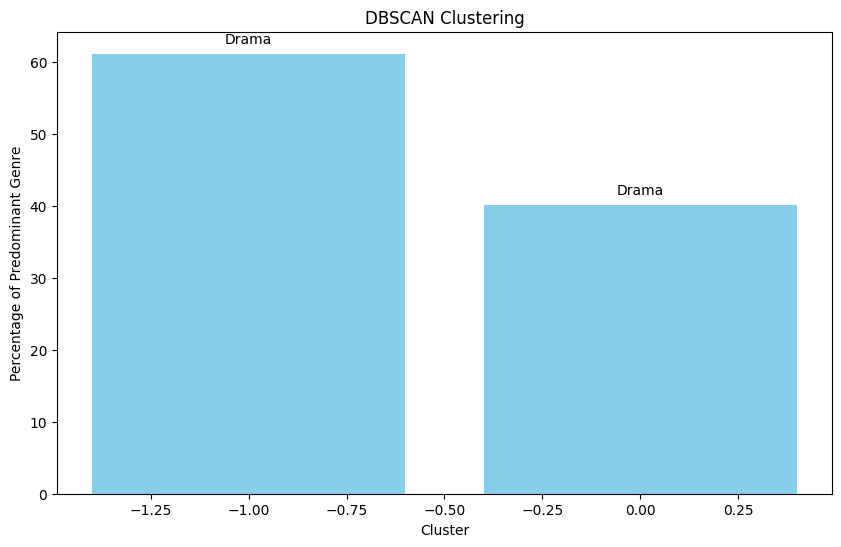

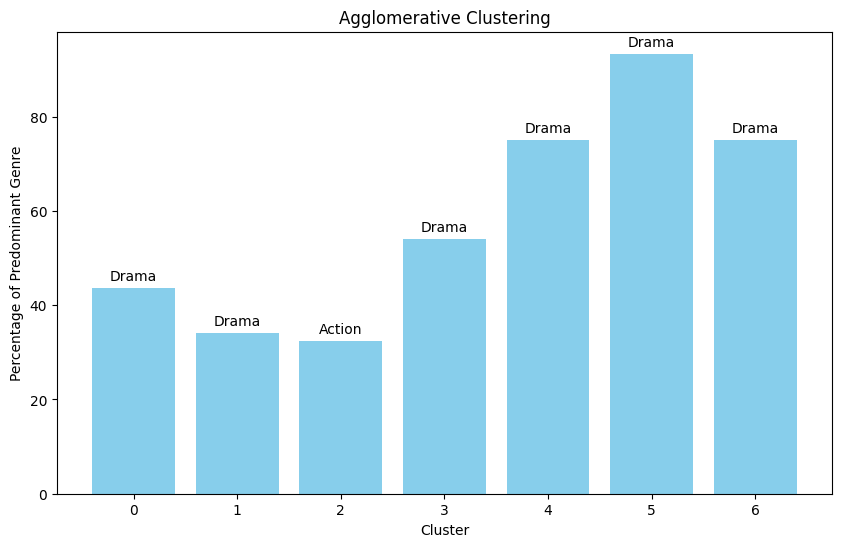

In [121]:
movies_in_ratings['kmeans_clusters'] = kmeans_clusters
movies_in_ratings['dbscan_clusters'] = dbscan_clusters
movies_in_ratings['agg_clusters'] = agg_clusters
cluster_visualization(movies_in_ratings, 'kmeans_clusters', 'Kmeans Clustering')
cluster_visualization(movies_in_ratings, 'dbscan_clusters', 'DBSCAN Clustering')
cluster_visualization(movies_in_ratings, 'agg_clusters', 'Agglomerative Clustering')

## Comentários dos Resultados Iniciais
No Kmeans, temos que o melhor da quantidade de clusters era 16 (método do cotovelo).

O dbscan, apesar de ter funcionado, não apresentou um resultado coerente, umas vez que os clusters estavam muito desproporcionais.

No que tange ao modelo hierárquico, decidi utilizar as mesma quantidade de clusters do Kmeans e funcionou bem, com os dados muito bem agrupados.


# Redução de Dimensionalidade
Vamos nos concentrar na redução de dimensionalidade do dataset. A redução de dimensionalidade é uma técnica importante, especialmente em conjuntos de dados grandes como este, para simplificar os modelos sem perder muita informação. Vamos aplicar duas técnicas populares: Análise de Componentes Principais (PCA) e Decomposição em Valores Singulares (SVD).

## Aplicação do PCA



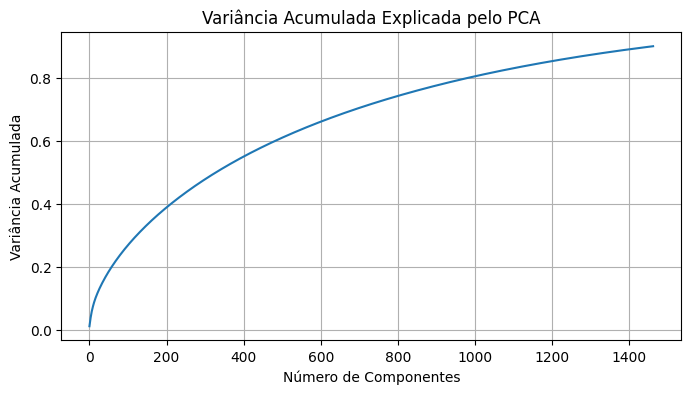

Número de componentes mantendo 90% da variância explicada: 1463


In [122]:
pca = PCA(n_components=0.9)  # Manter 90% da variância explicada
data_pca = pca.fit_transform(ratings_matrix_np_normalized)
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Variância Acumulada Explicada pelo PCA')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Acumulada')
plt.grid(True)
plt.show()
print(f'Número de componentes mantendo 90% da variância explicada: {pca.n_components_}')

## Aplicação do SVD



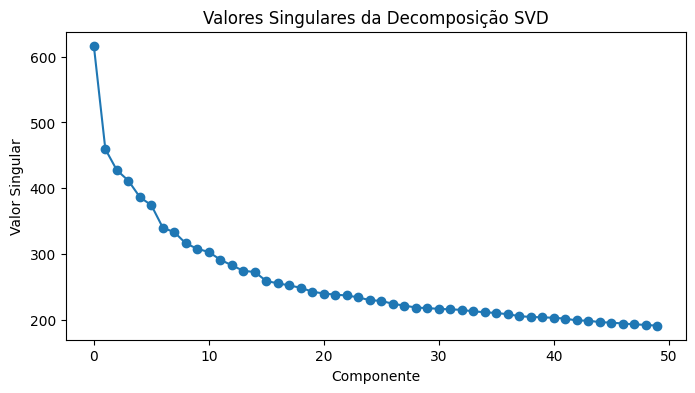

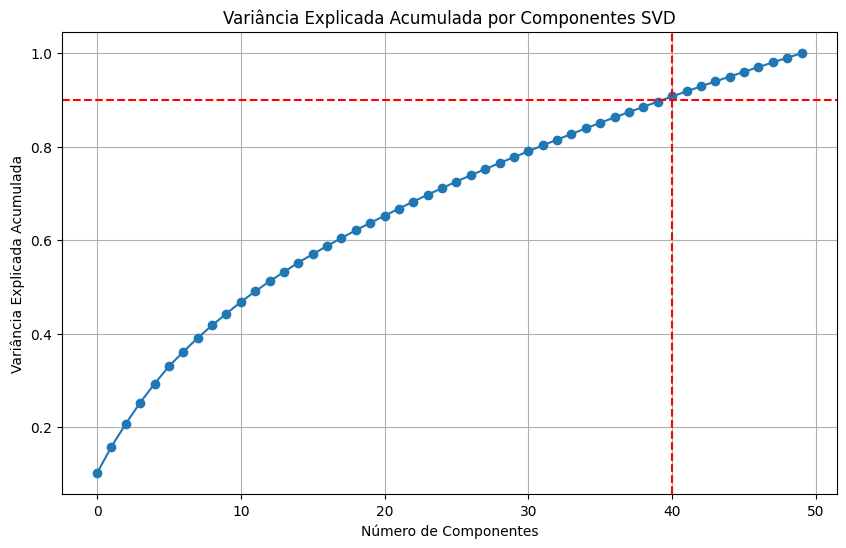

Número de componentes para atingir 90.0% da variância explicada: 41


In [123]:
svd = TruncatedSVD(n_components=50)  
data_svd = svd.fit_transform(ratings_matrix_np_normalized)

singular_values = svd.singular_values_

explained_variance = (singular_values ** 2) / np.sum(singular_values ** 2)

cumulative_explained_variance = np.cumsum(explained_variance)

target_variance = 0.90
n_components = np.argmax(cumulative_explained_variance >= target_variance) + 1

plt.figure(figsize=(8, 4))
plt.plot(singular_values, marker='o')
plt.title('Valores Singulares da Decomposição SVD')
plt.xlabel('Componente')
plt.ylabel('Valor Singular')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o')
plt.axhline(y=target_variance, color='r', linestyle='--')
plt.axvline(x=n_components - 1, color='r', linestyle='--')
plt.title('Variância Explicada Acumulada por Componentes SVD')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada Acumulada')
plt.grid(True)
plt.show()

print(f'Número de componentes para atingir {target_variance*100}% da variância explicada: {n_components}')

In [124]:
svd = TruncatedSVD(n_components=n_components, random_state=42)
svd_data = svd.fit_transform(ratings_matrix_np_normalized)

## Análise Parcial dos Resultados
- PCA:
    O gráfico mostra a variância acumulada explicada pelo PCA em função do número de componentes.
    Observa-se que são necessários 1528 componentes para explicar 90% da variância total.
    Isso indica uma alta dimensionalidade dos dados, sugerindo que muitas variáveis são relevantes para capturar a maior parte da informação presente nos dados originais.

- SVD:
    O primeiro gráfico mostra os valores singulares da decomposição SVD, com os primeiros componentes capturando a maior parte da variação.
    O segundo gráfico ilustra a variância explicada acumulada pelos componentes SVD.
    Observa-se que são necessários 41 componentes para atingir 90% da variância explicada.
    Isso sugere que o SVD é eficiente em reduzir a dimensionalidade dos dados, capturando a maior parte da variância com um número relativamente pequeno de componentes.

## Utilização dos Dados Reduzidos para Clusterização

### Kmeans

#### PCA

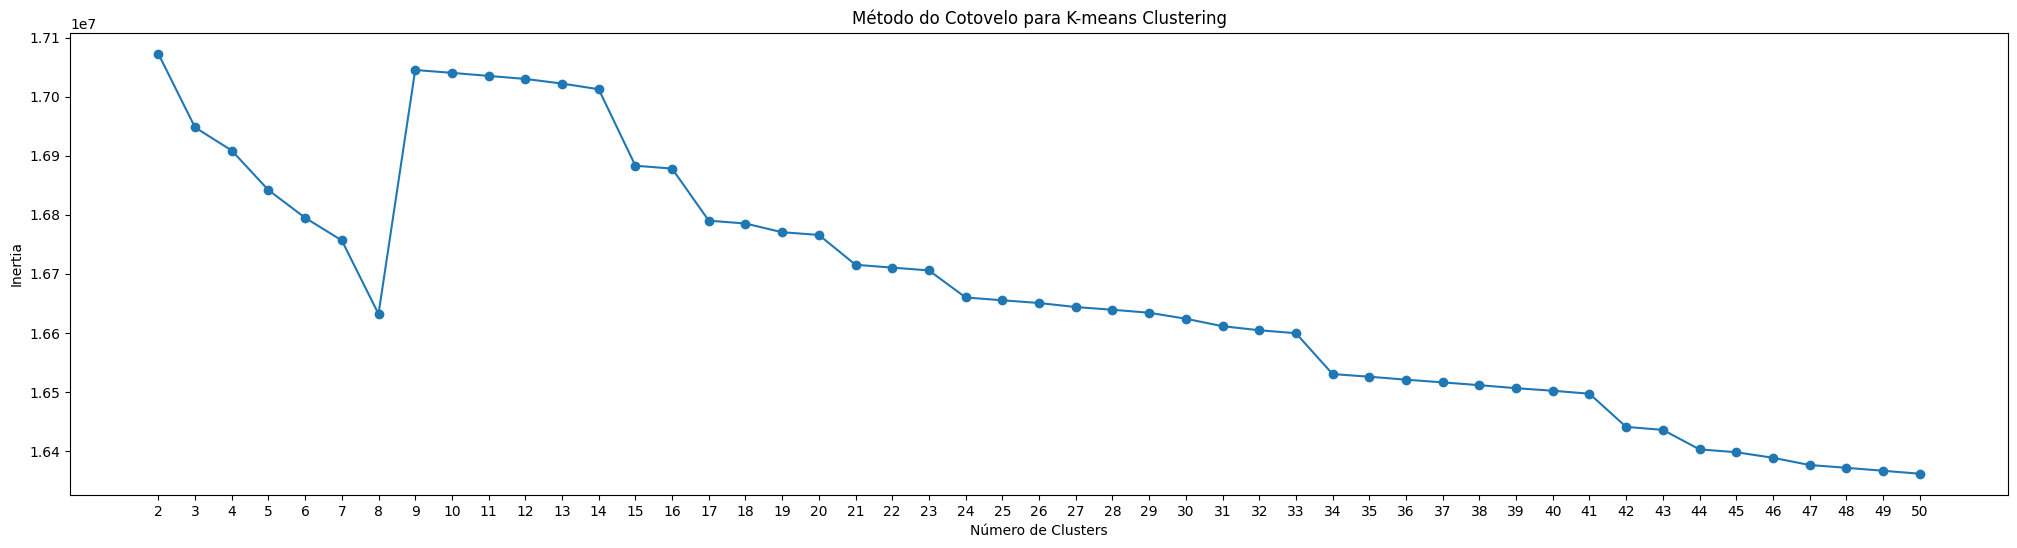

Número ótimo de clusters (KneeLocator): 8


In [125]:
inertia = calculate_wcss(data_pca)
plt.figure(figsize=(25, 6))
plt.plot(range(2, 51), inertia, marker='o')
plt.title('Método do Cotovelo para K-means Clustering')
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.xticks(range(2, 51))
plt.show()

kl_pca = KneeLocator(range(2, 51), inertia, curve="convex", direction="decreasing")
print(f'Número ótimo de clusters (KneeLocator): {kl_pca.elbow}')

In [126]:
kmeans_pca = KMeans(n_clusters=kl_pca.elbow, random_state=42)
kmeans_clusters_pca = kmeans_pca.fit_predict(data_pca)
print("Vizualização dos clusters formados pelo Kmeans:\n", pd.Series(kmeans_clusters_pca).value_counts())

Vizualização dos clusters formados pelo Kmeans:
 2    1065
5     613
7     589
1     569
4     308
6     288
0     140
3     119
Name: count, dtype: int64


#### SVD

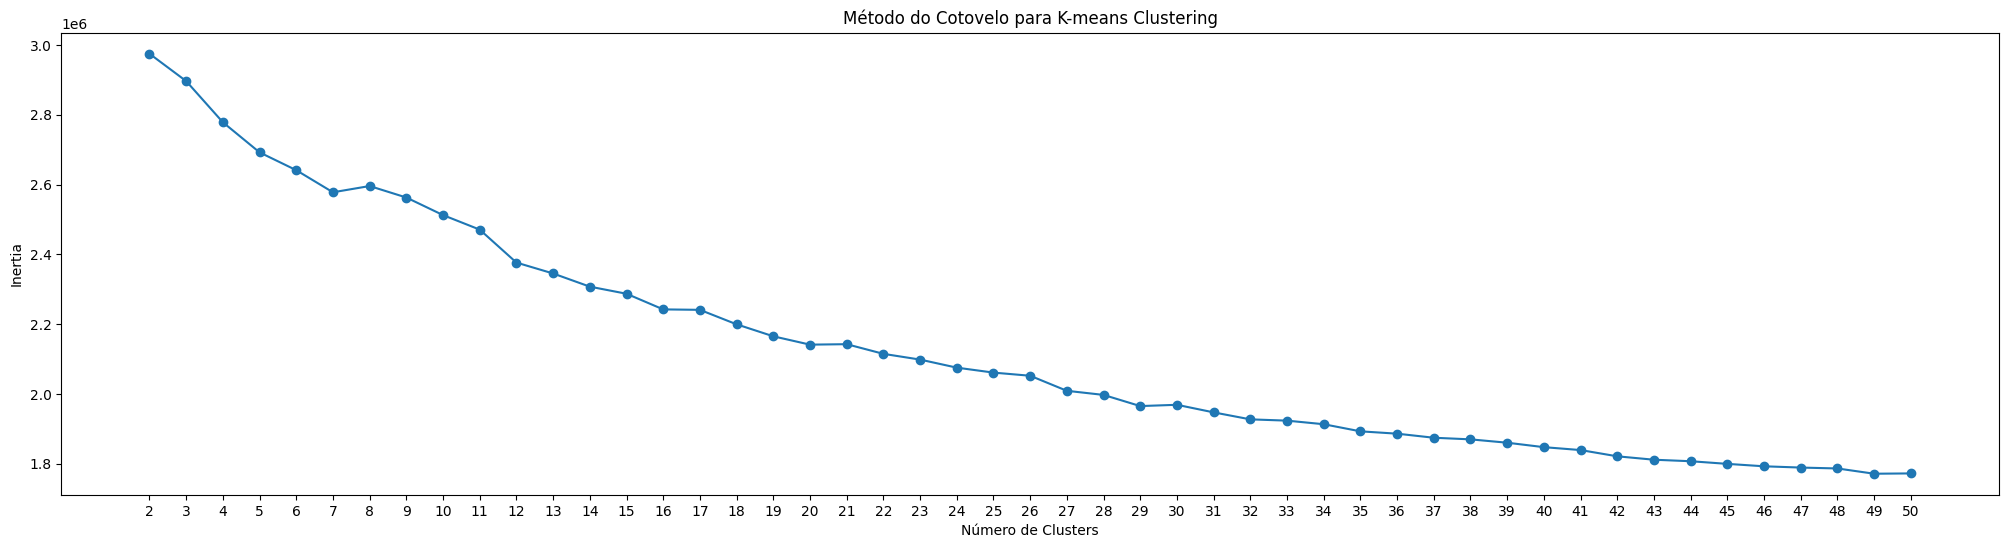

Número ótimo de clusters (KneeLocator): 7


In [127]:
inertia = calculate_wcss(svd_data)
plt.figure(figsize=(25, 6))
plt.plot(range(2, 51), inertia, marker='o')
plt.title('Método do Cotovelo para K-means Clustering')
plt.xlabel('Número de Clusters')
plt.ylabel('Inertia')
plt.xticks(range(2, 51))
plt.show()

kl_svd = KneeLocator(range(2, 51), inertia, curve="convex", direction="decreasing")
print(f'Número ótimo de clusters (KneeLocator): {kl_svd.elbow}')

In [128]:
kmeans_svd = KMeans(n_clusters=kl_svd.elbow, random_state=42)
kmeans_clusters_svd = kmeans_svd.fit_predict(svd_data)

print("Vizualização dos clusters formados pelo Kmeans:\n", pd.Series(kmeans_clusters_svd).value_counts())

Vizualização dos clusters formados pelo Kmeans:
 1    1469
4     820
5     741
6     264
0     158
2     135
3     104
Name: count, dtype: int64


### DBSCAN

#### PCA

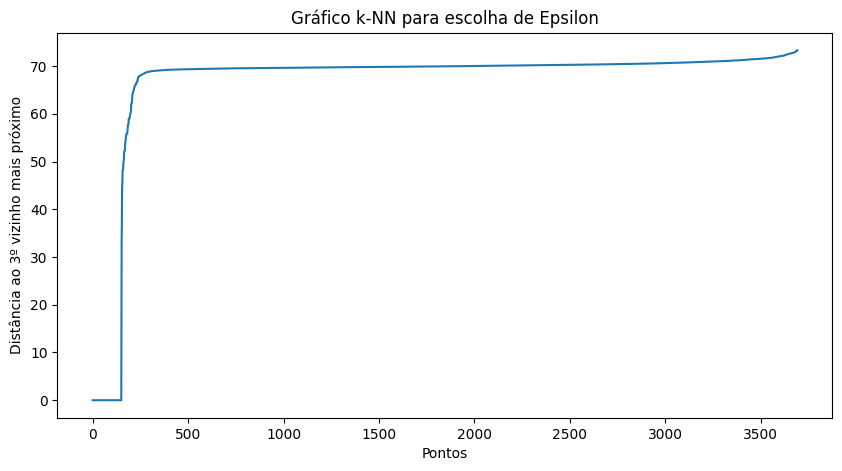

O valor sugerido para Epsilon é: 69.77078506367805


In [129]:
k = 4
neighbors = NearestNeighbors(n_neighbors=k)  
neighbors_fit = neighbors.fit(data_pca)
distances, indices = neighbors_fit.kneighbors(data_pca)
k_distances = distances[:, k-1]
epsilon = calculate_knee_point(k_distances)


sorted_distances = np.sort(distances[:, k-1], axis=0)  
plt.figure(figsize=(10, 5))
plt.plot(sorted_distances)
plt.title("Gráfico k-NN para escolha de Epsilon")
plt.xlabel("Pontos")
plt.ylabel("Distância ao 3º vizinho mais próximo")
plt.show()

print(f"O valor sugerido para Epsilon é: {k_distances[epsilon]}")

In [130]:

dbscan_pca = DBSCAN(eps=k_distances[epsilon], min_samples=k)
dbscan_pca_clusters = dbscan_pca.fit_predict(data_pca)
print("Visualização da formação de clusters:\n", pd.Series(dbscan_pca_clusters).value_counts())

Visualização da formação de clusters:
 -1    2302
 0    1369
 2       8
 1       4
 3       4
 4       4
Name: count, dtype: int64


#### SVD

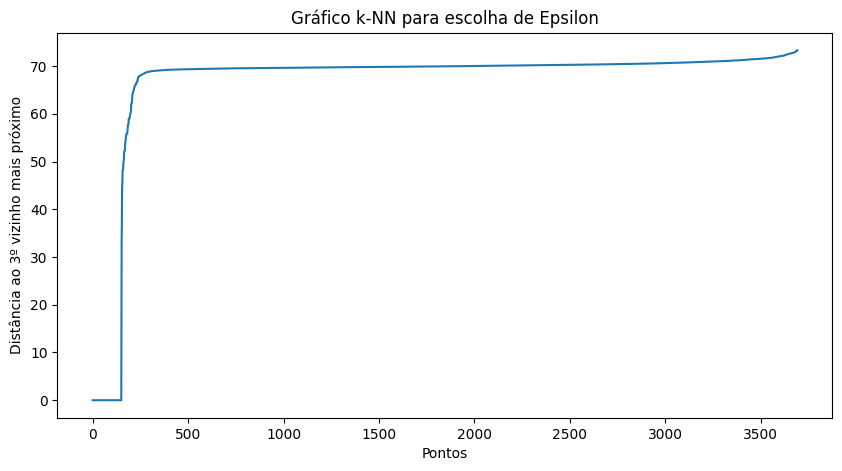

O valor sugerido para Epsilon é: 69.77078506367805


In [131]:
k = 4
neighbors = NearestNeighbors(n_neighbors=k)  
neighbors_fit = neighbors.fit(data_pca)
distances, indices = neighbors_fit.kneighbors(data_pca)
k_distances = distances[:, k-1]
epsilon = calculate_knee_point(k_distances)


sorted_distances = np.sort(distances[:, k-1], axis=0)  
plt.figure(figsize=(10, 5))
plt.plot(sorted_distances)
plt.title("Gráfico k-NN para escolha de Epsilon")
plt.xlabel("Pontos")
plt.ylabel("Distância ao 3º vizinho mais próximo")
plt.show()

print(f"O valor sugerido para Epsilon é: {k_distances[epsilon]}")

In [132]:

dbscan_svd = DBSCAN(eps=k_distances[epsilon], min_samples=k)
dbscan_svd_clusters = dbscan_svd.fit_predict(data_svd)
print("Visualização da formação de clusters:\n", pd.Series(dbscan_svd_clusters).value_counts())

Visualização da formação de clusters:
 0    3691
Name: count, dtype: int64


### Cluster Hierárquico

#### PCA

In [133]:
agg_pca_clustering = AgglomerativeClustering(n_clusters=kl_pca.elbow, linkage='complete')
agg_pca_clusters = agg_pca_clustering.fit_predict(data_pca)
print("Visualização da formação de clusters:\n", pd.Series(agg_pca_clusters).value_counts())

Visualização da formação de clusters:
 3    719
0    709
7    628
5    461
4    378
1    354
2    312
6    130
Name: count, dtype: int64


#### SVD

In [143]:
agg_svd_clustering = AgglomerativeClustering(n_clusters=kl_svd.elbow, linkage='complete')
agg_svd_clusters = agg_svd_clustering.fit_predict(data_svd)
print("Visualização da formação de clusters:\n", pd.Series(agg_svd_clusters).value_counts())

Visualização da formação de clusters:
 3    3264
2     207
1     126
5      32
6      30
0      23
4       9
Name: count, dtype: int64


## Visualização da Clusterização dos Dados Reduzidos


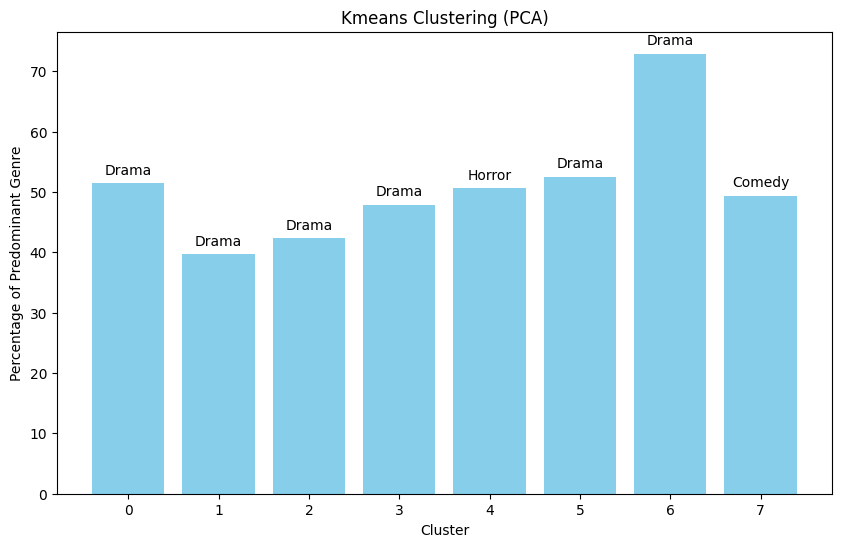

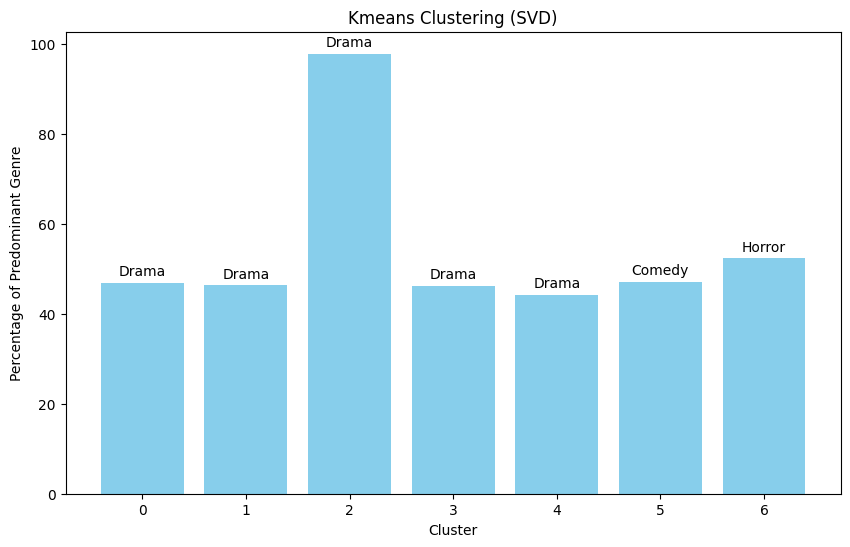

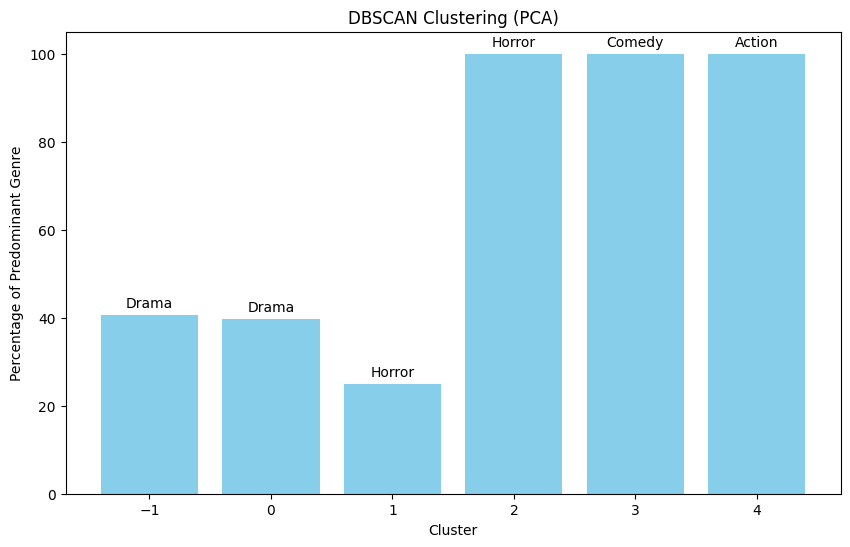

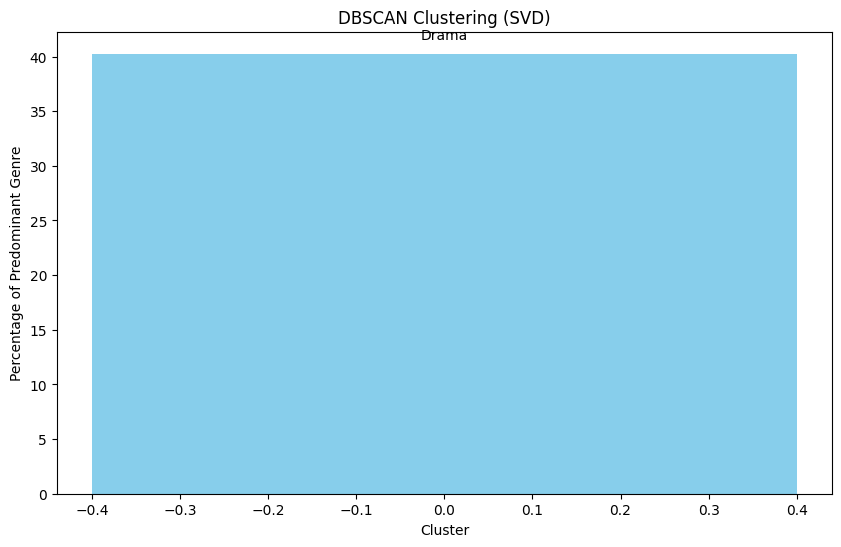

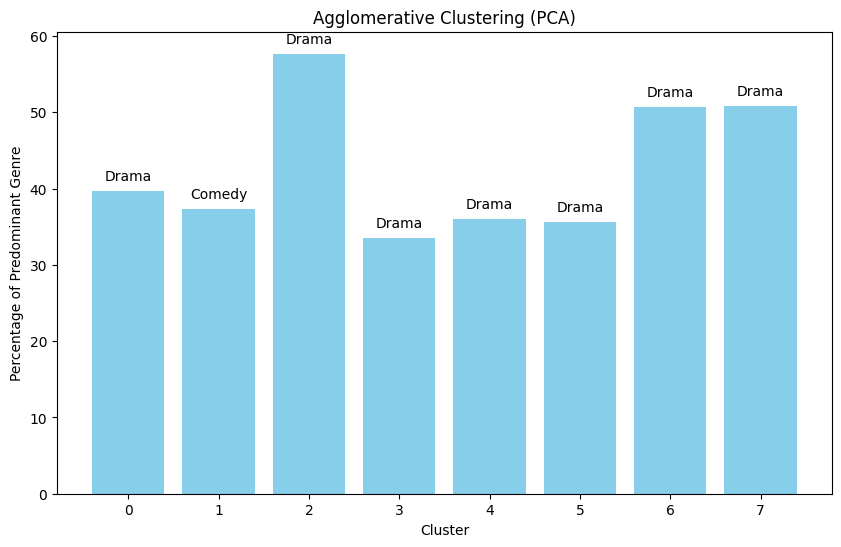

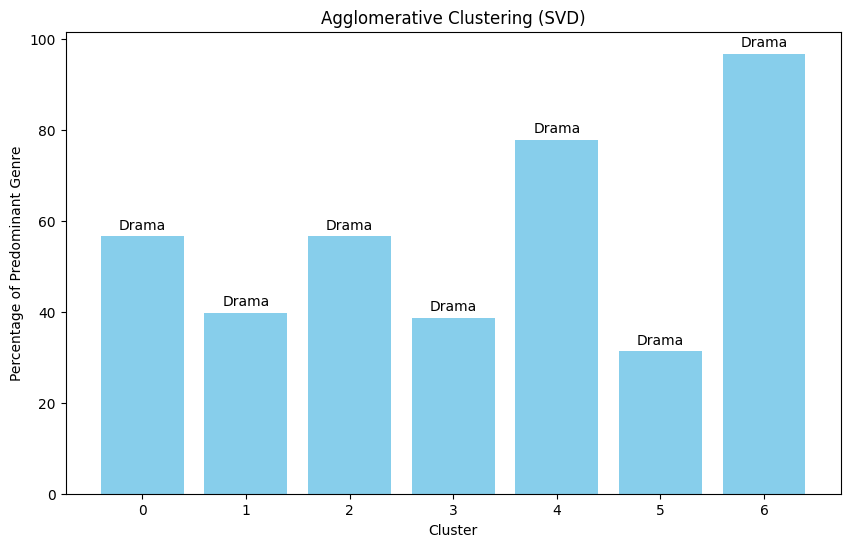

In [135]:
movies_in_ratings['kmeans_clusters_pca'] = kmeans_clusters_pca
movies_in_ratings['kmeans_clusters_svd'] = kmeans_clusters_svd
movies_in_ratings['dbscan_pca_clusters'] = dbscan_pca_clusters
movies_in_ratings['dbscan_svd_clusters'] = dbscan_svd_clusters
movies_in_ratings['agg_pca_clusters'] = agg_pca_clusters
movies_in_ratings['agg_svd_clusters'] = agg_svd_clusters
cluster_visualization(movies_in_ratings, 'kmeans_clusters_pca', 'Kmeans Clustering (PCA)')
cluster_visualization(movies_in_ratings, 'kmeans_clusters_svd', 'Kmeans Clustering (SVD)')
cluster_visualization(movies_in_ratings, 'dbscan_pca_clusters', 'DBSCAN Clustering (PCA)')
cluster_visualization(movies_in_ratings, 'dbscan_svd_clusters', 'DBSCAN Clustering (SVD)')
cluster_visualization(movies_in_ratings, 'agg_pca_clusters', 'Agglomerative Clustering (PCA)')
cluster_visualization(movies_in_ratings, 'agg_svd_clusters', 'Agglomerative Clustering (SVD)')

# Interpretação dos Clusters e Comparação dos Resultados
Na parte 7 do seu projeto, vamos focar na interpretação dos clusters gerados pelas técnicas de clusterização aplicadas anteriormente e na comparação dos resultados obtidos com e sem redução de dimensionalidade. Vamos analisar como os diferentes algoritmos agruparam os usuários do MovieLens e tentar entender as características dos clusters formados.

## Comparação dos Resultados com e sem Redução de Dimensionalidade
Agora, vamos comparar como a redução de dimensionalidade afetou a formação dos clusters.

In [146]:
# Cálculo do Davies-Bouldin Index
davies_bouldin_kmeans = davies_bouldin_score(ratings_matrix_np_normalized, kmeans_clusters)
davies_bouldin_dbscan = davies_bouldin_score(ratings_matrix_np_normalized, dbscan_clusters)
davies_bouldin_agg = davies_bouldin_score(dist_matrix_square, agg_clusters)
davies_bouldin_pca_kmeans = davies_bouldin_score(data_pca, kmeans_clusters_pca)
davies_bouldin_svd_kmeans = davies_bouldin_score(svd_data, kmeans_clusters_svd)
davies_bouldin_pca_dbscan = davies_bouldin_score(data_pca, dbscan_pca_clusters)
# davies_bouldin_svd_dbscan = davies_bouldin_score(data_svd, dbscan_svd_clusters)
davies_bouldin_pca_agg = davies_bouldin_score(data_pca, agg_pca_clusters)
davies_bouldin_svd_agg = davies_bouldin_score(data_svd, agg_svd_clusters)

# Cálculo do Calinski-Harabasz Index
calinski_harabasz_kmeans = calinski_harabasz_score(ratings_matrix_np_normalized, kmeans_clusters)
calinski_harabasz_dbscan = calinski_harabasz_score(ratings_matrix_np_normalized, dbscan_clusters)
calinski_harabasz_agg = calinski_harabasz_score(dist_matrix_square, agg_clusters)
calinski_harabasz_pca_kmeans = calinski_harabasz_score(data_pca, kmeans_clusters_pca)
calinski_harabasz_svd_kmeans = calinski_harabasz_score(svd_data, kmeans_clusters_svd)
calinski_harabasz_pca_dbscan = calinski_harabasz_score(data_pca, dbscan_pca_clusters)
# calinski_harabasz_svd_dbscan = calinski_harabasz_score(data_svd, dbscan_svd_clusters)
calinski_harabasz_pca_agg = calinski_harabasz_score(data_pca, agg_pca_clusters)
calinski_harabasz_svd_agg = calinski_harabasz_score(data_svd, agg_svd_clusters)

print(f'Davies-Bouldin Index Kmeans com dados originais: {davies_bouldin_kmeans}')
print(f'Davies-Bouldin Index DBSCAN com dados originais: {davies_bouldin_dbscan}')
print(f'Davies-Bouldin Index Agglomerative com dados originais: {davies_bouldin_agg}')
print(f'Davies-Bouldin Index Kmeans com PCA: {davies_bouldin_pca_kmeans}')
print(f'Davies-Bouldin Index Kmeans com SVD: {davies_bouldin_svd_kmeans}')
print(f'Davies-Bouldin Index DBSCAN com PCA: {davies_bouldin_pca_dbscan}')
# print(f'Davies-Bouldin Index DBSCAN com SVD: {davies_bouldin_svd_dbscan}')
print(f'Davies-Bouldin Index Agglomerative com PCA: {davies_bouldin_pca_agg}')
print(f'Davies-Bouldin Index Agglomerative com SVD: {davies_bouldin_svd_agg}')

print(f'Calinski-Harabasz Index Kmeans com dados originais: {calinski_harabasz_kmeans}')
print(f'Calinski-Harabasz Index DBSCAN com dados originais: {calinski_harabasz_dbscan}')
print(f'Calinski-Harabasz Index Agglomerative com dados originais: {calinski_harabasz_agg}')
print(f'Calinski-Harabasz Index Kmeans com PCA: {calinski_harabasz_pca_kmeans}')
print(f'Calinski-Harabasz Index Kmeans com SVD: {calinski_harabasz_svd_kmeans}')
print(f'Calinski-Harabasz Index DBSCAN com PCA: {calinski_harabasz_pca_dbscan}')
# print(f'Calinski-Harabasz Index DBSCAN com SVD: {calinski_harabasz_svd_dbscan}')
print(f'Calinski-Harabasz Index Agglomerative com PCA: {calinski_harabasz_pca_agg}')
print(f'Calinski-Harabasz Index Agglomerative com SVD: {calinski_harabasz_svd_agg}')


Davies-Bouldin Index Kmeans com dados originais: 8.859175648653428
Davies-Bouldin Index DBSCAN com dados originais: 7.475719265720075
Davies-Bouldin Index Agglomerative com dados originais: 2.6648614649484306
Davies-Bouldin Index Kmeans com PCA: 7.8536802614313945
Davies-Bouldin Index Kmeans com SVD: 2.7995090230219617
Davies-Bouldin Index DBSCAN com PCA: 11.79740665400963
Davies-Bouldin Index Agglomerative com PCA: 17.810802718401202
Davies-Bouldin Index Agglomerative com SVD: 3.137700754375993
Calinski-Harabasz Index Kmeans com dados originais: 16.86164676516754
Calinski-Harabasz Index DBSCAN com dados originais: 1.2560162698173745
Calinski-Harabasz Index Agglomerative com dados originais: 4436.847224429211
Calinski-Harabasz Index Kmeans com PCA: 18.23855182927266
Calinski-Harabasz Index Kmeans com SVD: 126.43400473660229
Calinski-Harabasz Index DBSCAN com PCA: 3.2652220550147155
Calinski-Harabasz Index Agglomerative com PCA: 3.9328026198358095
Calinski-Harabasz Index Agglomerative c

# Conclusão

**Principais Descobertas:**
- A Clusterização Hierárquica com dados originais é consistentemente o melhor método em termos de compacidade e separabilidade dos clusters (menor índice de Davies-Bouldin) e densidade e separação (maior índice de Calinski-Harabasz). Este método parece funcionar muito bem sem necessidade de redução dimensional.
Kmeans com SVD é a segunda melhor opção, mostrando boa performance tanto nos índices de Davies-Bouldin quanto Calinski-Harabasz. A aplicação de SVD melhora significativamente a performance do Kmeans.
DBSCAN não performa bem em nenhum cenário, indicando que esse método pode não ser adequado para este conjunto de dados específico ou que os parâmetros precisam ser ajustados.
A redução dimensional via PCA não parece beneficiar os algoritmos de clusterização, especialmente para o DBSCAN e Clusterização Hierárquica, conforme mostrado valores nos índices de Davies-Bouldin e Calinski-Harabasz.

**Desafios Enfrentados:**
- A escolha de parâmetros para DBSCAN e o número de clusters para K-means foi desafiadora, requerendo várias iterações para otimização.
- Lidar com a alta dimensionalidade dos dados foi complexo, necessitando de técnicas de redução de dimensionalidade como PCA e SVD.

**Sugestões para Melhorias Futuras:**
- Implementar métodos mais avançados de otimização de parâmetros, como busca em grade ou algoritmos evolutivos.
- Explorar modelos mais complexos de clusterização que possam lidar com a alta dimensionalidade sem a necessidade de redução prévia.
- Utilizar métodos de aprendizado de máquina para prever as avaliações dos usuários e melhorar as recomendações de filmes.

Este trabalho estabeleceu uma base sólida para futuras pesquisas e desenvolvimento de sistemas de recomendação mais robustos e personalizados.
